In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score  
# Ensure NLTK data is downloaded 
# nltk.download('punkt')
# nltk.download('stopwords')


In [2]:
# Load the dataset
data = pd.read_csv("cleaned_modified_recipe.csv")
print("Data loaded successfully!")

Data loaded successfully!


In [3]:
# Check the structure of the DataFrame
print("DataFrame columns:", data.columns)

DataFrame columns: Index(['title', 'ingredients', 'steps', 'cuisine', 'rating'], dtype='object')


In [4]:
print("Sample data:\n", data.head())

Sample data:
                   title                                ingredients  \
0  Spaghetti Delight! .        pepper, cheese, olive oil, pasta! .   
1  Herbal Lemon Rice! .  basil, butter, lemon, cumin, olive oil! .   
2  Sugar Glazed Rice! .                                        ! .   
3     Golden Chicken! .           chicken, flour, egg, turmeric! .   
4  Spaghetti Delight! .      lemon, potato, tomato, rice, chili! .   

                                               steps      cuisine  rating  
0     Serve hot -> Boil water -> Chop ingredients! .    INDIAN! .     2.0  
1  heat oil -> add seasoning -> garnish with herb...   MEXICAN! .     3.0  
2  Add seasoning -> Let it simmer -> Heat oil -> ...      THAI! .     3.0  
3  Bake at 350°F -> Let it simmer -> Add seasonin...   ITALIAN! .     5.0  
4  Add seasoning -> Let it simmer -> Boil water -...  AMERICAN! .     3.0  


In [5]:
# Drop columns with a large amount of null values
threshold = 0.5  # For example, drop columns with more than 50% missing values
missing_percentage = data.isnull().mean()  # Calculate missing values percentage
columns_to_drop = missing_percentage[missing_percentage > threshold].index
data.drop(columns=columns_to_drop, inplace=True)

# Print the updated DataFrame columns to check
print("Columns after dropping those with high null values:", data.columns)

Columns after dropping those with high null values: Index(['title', 'ingredients', 'steps', 'cuisine', 'rating'], dtype='object')


In [6]:
print("values after dropping those with high null values:", data.head(5))

values after dropping those with high null values:                   title                                ingredients  \
0  Spaghetti Delight! .        pepper, cheese, olive oil, pasta! .   
1  Herbal Lemon Rice! .  basil, butter, lemon, cumin, olive oil! .   
2  Sugar Glazed Rice! .                                        ! .   
3     Golden Chicken! .           chicken, flour, egg, turmeric! .   
4  Spaghetti Delight! .      lemon, potato, tomato, rice, chili! .   

                                               steps      cuisine  rating  
0     Serve hot -> Boil water -> Chop ingredients! .    INDIAN! .     2.0  
1  heat oil -> add seasoning -> garnish with herb...   MEXICAN! .     3.0  
2  Add seasoning -> Let it simmer -> Heat oil -> ...      THAI! .     3.0  
3  Bake at 350°F -> Let it simmer -> Add seasonin...   ITALIAN! .     5.0  
4  Add seasoning -> Let it simmer -> Boil water -...  AMERICAN! .     3.0  


In [7]:
# Drop duplicates and impute missing values
data.drop_duplicates(inplace=True)
if 'rating' in data.columns:
    data['rating'] = data['rating'].fillna(data['rating'].median())
data.dropna(subset=['ingredients', 'steps'], inplace=True)

In [8]:
# Text Preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]  # Remove stopwords and punctuation
    return ' '.join(tokens)

# Apply preprocessing to the ingredients
data['Processed Ingredients'] = data['ingredients'].apply(preprocess_text)


In [9]:
# Convert the ingredients list to a binary matrix for KNN
data['ingredients'] = data['ingredients'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
ingredients_matrix = mlb.fit_transform(data['ingredients'])

# Scaling the data for KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ingredients_matrix)


In [10]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
data['cluster_kmeans'] = clusters

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

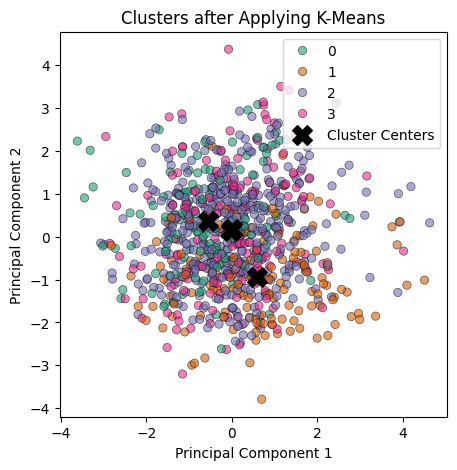

In [11]:
# Plotting the clusters after applying K-Means
plt.figure(figsize=(5,5))
sns.scatterplot(x=X_pca[:, 0], 
                y=X_pca[:, 1], 
                hue=data['cluster_kmeans'], 
                palette='Dark2', 
                alpha=0.6, 
                edgecolor='k')

# Adding the cluster centers
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='black', s=200, marker='X', label='Cluster Centers')

plt.title('Clusters after Applying K-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(False)
plt.show()


In [12]:
# Split the data into training and testing sets for KNN
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    data['rating'], 
    test_size=0.2,  # 20% for testing
    random_state=42
)

In [13]:
# Train the KNN model on the training set
n_neighbors = min(len(data), 5)
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
knn.fit(X_train)


NearestNeighbors(metric='cosine')

In [14]:
# Function to evaluate model fit and plot accuracy graph
def plot_train_test_distribution(X_train, X_test, y_train, y_test):
    train_errors = []
    test_errors = []
    neighbors_range = range(1, 21)

    for n_neighbors in neighbors_range:
        knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
        knn.fit(X_train)
    
        train_distances, train_indices = knn.kneighbors(X_train)
        test_distances, test_indices = knn.kneighbors(X_test)
    #
    # Compute mean squared error for training and testing
        train_pred = [y_train.iloc[idx].mean() for idx in train_indices]
        test_pred = [y_train.iloc[idx].mean() for idx in test_indices]
        train_errors.append(mean_squared_error(y_train, train_pred))
        test_errors.append(mean_squared_error(y_test, test_pred))

      # # Round predictions to compare with actual ratings
      #   train_accuracies.append(accuracy_score(y_train.round(), pd.Series(train_pred).round()))
      #   test_accuracies.append(accuracy_score(y_test.round(), pd.Series(test_pred).round()))

# Plot train vs test error
    plt.figure(figsize=(6, 4))
    plt.plot(neighbors_range, train_errors, label='Training Error', marker='o', color='blue')
    plt.plot(neighbors_range, test_errors, label='Testing Error', marker='o', color='orange')
    plt.title('Training and Testing Errors vs Number of Neighbors')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
# Function to recommend recipes based on user input ingredients
def recommended(user_input):
    # Normalize dataset ingredients to lowercase
    data['ingredients'] = data['ingredients'].apply(lambda x: [ingredient.lower() for ingredient in x])
    
    # Validate input ingredients against the dataset
    all_ingredients = set(ingredient for sublist in data['ingredients'] for ingredient in sublist)
    user_input = [ingredient.strip().lower() for ingredient in user_input.split(',')]
    
    # Filter out invalid ingredients
    valid = [ingredient for ingredient in user_input if ingredient in all_ingredients]

    if not valid:
        print("Error: None of the entered ingredients match the dataset. Please try again with valid ingredients.")
        return

    print(f"Valid Ingredients: {', '.join(valid)}")

    # Convert valid user ingredients to the binary vector format
    user_vector = mlb.transform([valid])

    # Find nearest recipes
    distances, indices = knn.kneighbors(user_vector)
    
    # Get the recommended recipes using the indices
    recommended_recipes = data.iloc[indices[0]]

    # Display recommendations with actual recipe names, steps, cuisine, and rating
    if indices[0].size > 0:
        print("\nHere are some recipes you can try based on the ingredients:")
        for idx, row in recommended_recipes.iterrows():
            print(f"\n- Recipe Name: {row['title']}")
            print(f"  Cuisine: {row['cuisine']}")
            print(f"  Rating: {row['rating']}")
            print(f"  Steps: {row['steps']}")
            print(f"  Ingredients: {', '.join(row['ingredients'])}")
        
        # Create a graph for the cosine distances and ratings
        plt.figure(figsize=(5, 5))
        sns.barplot(x=recommended_recipes.index, y=recommended_recipes['rating'])
        plt.title("Ratings for Recipe Recommendations")
        plt.xlabel("Recipe Index")
        plt.ylabel("Rating")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("No matching recipes found based on the provided ingredients.")



Enter ingredients separated by commas for recipe recommendations (e.g., tomato, onion, garlic):  onion,lime


Valid Ingredients: onion

Here are some recipes you can try based on the ingredients:

- Recipe Name: Golden Chicken! .
  Cuisine: FRENCH! .
  Rating: 3.0
  Steps: Bake at 350°F -> Chop ingredients -> Mix ingredients! .
  Ingredients: lemon,  tomato,  butter,  salt,  cumin,  garlic! .

- Recipe Name: Sugar Glazed Rice! .
  Cuisine: INDIAN! .
  Rating: 5.0
  Steps: Boil water -> Heat oil -> Garnish with herbs -> Bake at 350°F -> Serve hot! .
  Ingredients: cumin,  sugar,  lemon! .

- Recipe Name: Spaghetti Delight! .
  Cuisine: THAI! .
  Rating: 1.0
  Steps: Add seasoning -> Mix ingredients -> Let it simmer -> Chop ingredients! .
  Ingredients: cumin,  basil,  vanilla! .

- Recipe Name: Sweet & Spicy Carrot! .
  Cuisine: ITALIAN! .
  Rating: 2.0
  Steps: Boil water -> Let it simmer -> Heat oil -> Mix ingredients -> Serve hot! .
  Ingredients: rice,  egg,  potato! .

- Recipe Name: Spaghetti Delight! .
  Cuisine: CHINESE! .
  Rating: 1.0
  Steps: Heat oil -> Mix ingredients -> Garnish wi

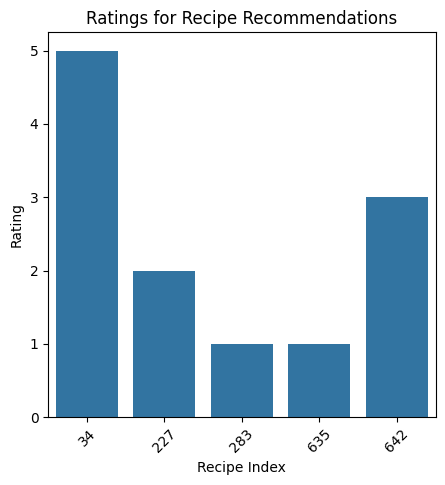

In [16]:
# User Input for KNN-based recipe recommendation
user_ingredients = input("\nEnter ingredients separated by commas for recipe recommendations (e.g., tomato, onion, garlic): ")
if user_ingredients.strip():
    recommended(user_ingredients)
else:
    print("Error: No ingredients entered. Please try again.")


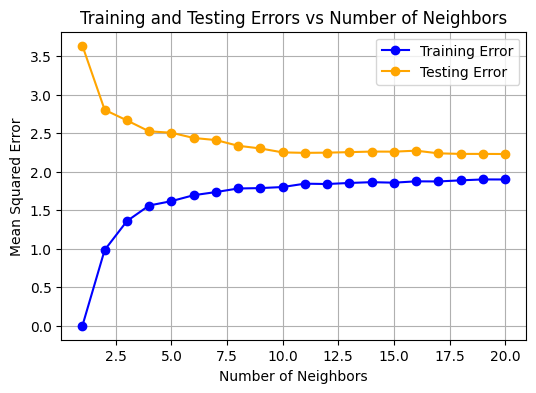

In [17]:
# Call the function to plot accuracy graph
plot_train_test_distribution(X_train, X_test, y_train, y_test)
